### Import required libraries

In [185]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

nltk.download("wordnet")


[nltk_data] Downloading package wordnet to C:\Users\Vaishali
[nltk_data]     Agarwal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [159]:

def download_stopwords():
    nltk.download("stopwords", quiet = True)
    stopwords = nltk.corpus.stopwords.words("english")
    return stopwords


### Load the data

In [160]:
def load_data(filepath = "./emails.csv"):
    data = pd.read_csv(filepath)
    return data

data = load_data()

In [161]:
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [162]:
data["length"] = data["text"].apply(len)

In [163]:
data.describe()

,spam,length
count,5728.000000,5728.000000
mean,0.238827,1556.768680
std,0.426404,2042.649812
min,0.000000,13.000000
25%,0.000000,508.750000
50%,0.000000,979.000000
75%,0.000000,1894.250000
max,1.000000,43952.000000


In [164]:
## remove outliers with text of length more than 20000
data = data[data["length"] < 20000].reset_index(drop=True)

In [165]:
data.groupby("spam").describe()

length                                                                 
       count         mean          std   min    25%     50%      75%      max
spam                                                                         
0     4356.0  1599.691001  1631.733291  13.0  576.5  1121.5  2035.00  18375.0
1     1366.0  1281.918009  2073.366727  18.0  400.5   693.0  1237.75  19174.0

Observe that minimum and maximum lengths of texts in spam and non-spam emails are almost same.

### Exploratory data analysis

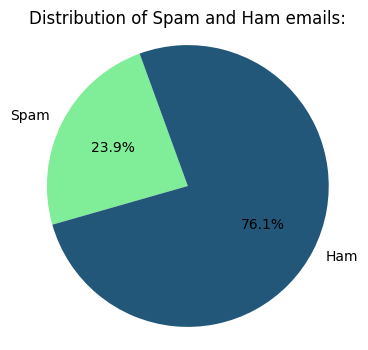

In [166]:
## distribution of spam and non-spam(ham) emails 

spam_data = data[data["spam"] == 1]
ham_data = data[data["spam"] == 0]

num_spam = len(spam_data)
num_ham = len(ham_data)
counts = [num_spam, num_ham]

labels = ["Spam", "Ham"]
colors = ["#80ed99", "#22577a"]

plt.figure(figsize = (4, 4))
plt.pie(counts, labels = labels, colors = colors, startangle = 110, autopct = "%1.1f%%")
plt.title("Distribution of Spam and Ham emails:")
plt.axis("equal")
plt.show()

### Data Pre-processing

In [167]:
## drop column length as it not giving any specific information
## make a copy of the data
data_1 = data.copy()
## drop column "length"
data_1.drop(["length"], axis = 1, inplace = True)

In [173]:
def pre_process(data):
    
    ## convert the text into lower case
    data["text"] = data["text"].apply(str.lower)

    ## remove the punctuations from the text column
    remove_punc = str.maketrans("", "", string.punctuation)
    data["text"] = data["text"].apply(lambda x: x.translate(remove_punc))

    ## remove the words "subject" and "re" from the text column
    data["text"] = data["text"].apply(lambda x: x.replace("subject", "", 1))
    data["text"] = data["text"].apply(lambda x: x.replace("re", "", 1))

    ## remove numbers from the text column
    data["text"] = data["text"].apply(lambda x: re.sub(r"\d+", "", x))

    ## remove stopwords from the text column
    stopwords = download_stopwords()

    ## split the sentence into words to figure out the stopwords, use whitespacetokenizer for that
    tokenizer = WhitespaceTokenizer()
    data["text"] = data["text"].apply(lambda x: tokenizer.tokenize(x))
    data["text"] = data["text"].apply(lambda x: [word for word in x if word not in stopwords])

    ## lemmatization using the wordnet
    lemmatizer = WordNetLemmatizer()
    data["text"] = data["text"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    ## remove single character words
    data["text"] = data["text"].apply(lambda x: [word for word in x if len(word)>1])

    ## join the tokens into the string
    data["text"] = data["text"].apply(lambda x: " ".join(x))

    return data


In [174]:
data_1 = pre_process(data_1)

In [175]:
data_1

,text,spam
0,naturally irsistible corporate identity lt all...,1
1,stock trading gunslinger fanny merrill muzo co...,1
2,unbelievable new home made easy im wanting sho...,1
3,color printing special quest additional inform...,1
4,money get softwa cd softwa compatibility great...,1
...,...,...
5717,search development charge gpg forwarded shirle...,0
5718,ceipt visit jim thanks invitation visit lsu sh...,0
5719,enron case study update wow day super thank mu...,0
5720,intest david please call shirley crenshaw assi...,0


In [182]:
def display_wordcloud(words):

    wordcloud_spam = WordCloud(width = 500, height = 300, background_color = "white").generate(words)
    plt.figure(figsize = (10, 5))
    plt.imshow(wordcloud_spam, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

def wordcloud():
    spam_words = data_1[data_1["spam"] == 1].text.str.cat(sep = " ")
    ham_words = data_1[data_1["spam"] == 0].text.str.cat(sep = " ")

    print("WordCloud of Spam words:")
    display_wordcloud(spam_words)

    print("WordCloud of Ham Words:")
    display_wordcloud(ham_words)


WordCloud of Spam words:


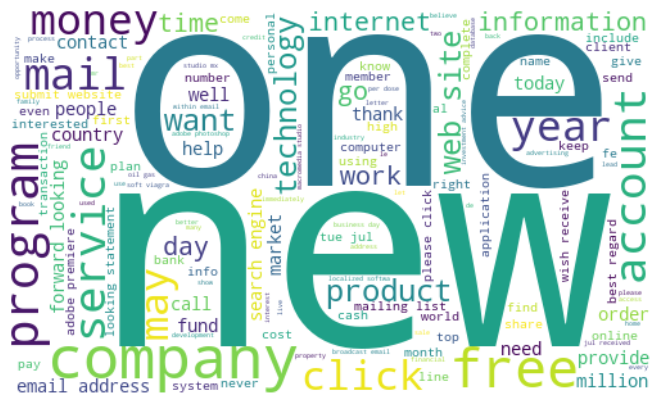

WordCloud of Ham Words:


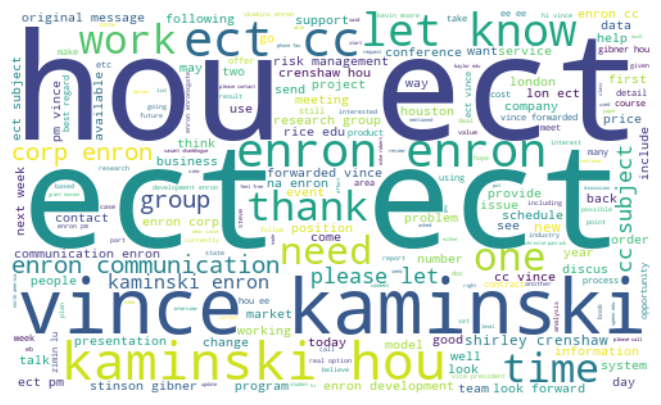

In [184]:
wordcloud()

#### Clearly, from both the WordClouds we can observe the difference in frequently occuring words. 
#### In the ham wordcloud, there are more business words like work, time, communication, cc, presentation etc. The other frequently seen words are "enron" which is the company's name, "ect" stands for "Enron Capital and Trade Resources", "hou" stands for houston where the company is based of,  "vince kaminski" is the name of the manager worked in ECT. 
#### Whereas in the spam wordcloud, the words like new, free, service, companny, website, click, account etc. are frequently occurred which explains the use of these words in the spam emails.

## Train Validation Test Split

In [206]:
def train_val_test(data):
    X_train, X_test, y_train, y_test = train_test_split(data.drop("spam", axis = 1), data["spam"], test_size = 0.1, random_state = 54)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.11, random_state = 54)

    train = pd.concat([X_train, y_train], axis = 1, join = "inner")
    val = pd.concat([X_val, y_val], axis = 1, join = "inner")
    test = pd.concat([X_test, y_test], axis = 1, join = "inner")

    print("Shapes of Train Validation Test split: ")
    print("Train shape {}".format((train.shape)))
    print("Validation shape {}".format((val.shape)))
    print("Test shape {}".format((test.shape)))

    return train, val, test

In [208]:
train, validation, test = train_val_test(data_1)

Shapes of Train Validation Test split: 
Train shape (4582, 2)
Validation shape (567, 2)
Test shape (573, 2)


#### Store the data in .csv files

In [213]:
train.to_csv("train.csv", header = True, index = False)
validation.to_csv("validation.csv", header = True, index = False)
test.to_csv("test.csv", header = True, index = False)